In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

## Part 1: Optimal Transport in 1D

In [2]:
mean_1, mean_2 = 25, 100
std_dev_1, std_dev_2 = 5, 10
n = 10000

### Sample from two Gaussian Distributions

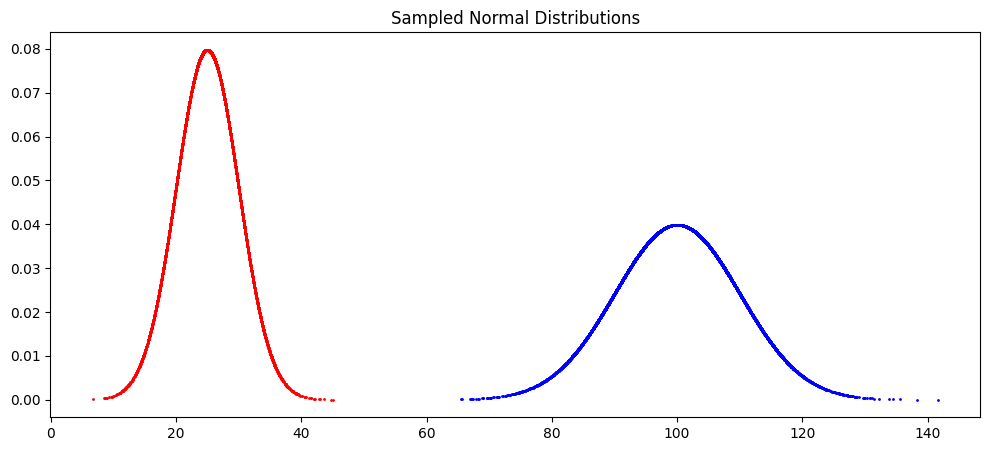

In [3]:
np.random.seed(1)

gauss_x_1 = np.random.normal(mean_1, std_dev_1, n)
gauss_x_2 = np.random.normal(mean_2, std_dev_2, n)

plt.figure(figsize=(12, 5)) 
plt.plot(gauss_x_1, norm.pdf(gauss_x_1, mean_1, std_dev_1), 'ro', markersize=1)
plt.plot(gauss_x_2, norm.pdf(gauss_x_2, mean_2, std_dev_2), 'bo', markersize=1)
plt.title('Sampled Normal Distributions')
plt.show()

### Comparison of closed-form optimal transport and optimal transport between sampled distributions (2-Wasserstein distance in both)

In [4]:
def closed_form_ot():
    return (mean_1 - mean_2) ** 2 + (std_dev_1 ** 2 + std_dev_2 ** 2 - 2 * std_dev_1 * std_dev_2)

def optimal_transport():
    """
    Calculate the optimal transport between samples of 2 distributions

    Returns: - int: optimal transport value
             - np.array: sorted values from the first distribution
             - np.array: sorted values from the second distribution   
    """
    x_points = np.sort(gauss_x_1)
    y_points = np.sort(gauss_x_2)

    diff = x_points - y_points
    optimal_transp = np.sum(np.square(diff)) / n

    return optimal_transp, x_points, y_points

closed_ot = closed_form_ot()
ot, x, y = optimal_transport()
print("Closed form optimal transport: ", closed_ot)
print("Approximate optimal transport with " + str(n) + " samples: ", ot)

Closed form optimal transport:  5650
Approximate optimal transport with 10000 samples:  5657.02205355342


### Interpolation between distributions with optimal transport

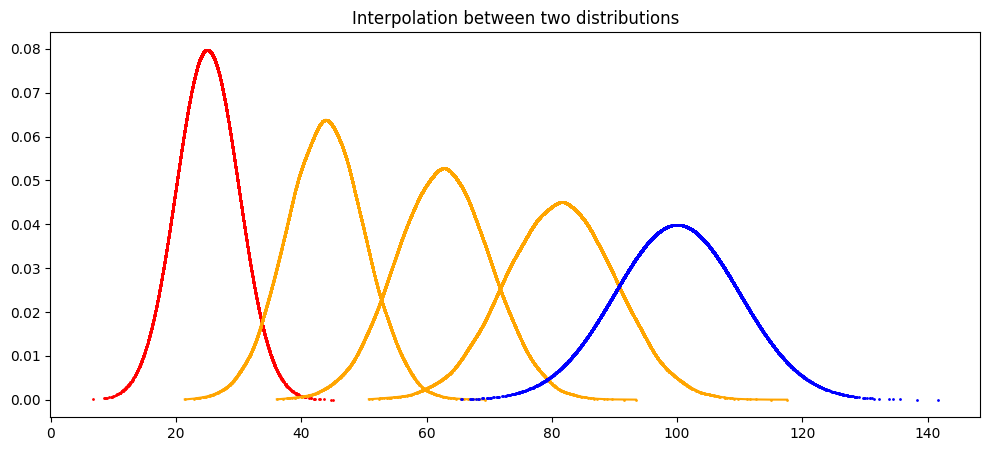

In [5]:
lambdas = [0.25, 0.5, 0.75]
plt.figure(figsize=(12, 5)) 
plt.plot(x, norm.pdf(x, mean_1, std_dev_1), 'ro', markersize=1)
for l in lambdas:
    new_p = l * x + (1 - l) * y
    kde = gaussian_kde(new_p)
    plt.plot(new_p, kde(new_p), marker='o', color='orange', markersize=1)

plt.plot(y, norm.pdf(y, mean_2, std_dev_2), 'bo', markersize=1)
plt.title('Interpolation between two distributions')
plt.show()

## Part 2: Color Transfer Using Sliced OT

In [6]:
import cv2

In [7]:
dst_img = np.array(cv2.imread("dst.png"))
dst_img = cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB) / 255
src_img = np.array(cv2.imread("src.png"))
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB) / 255

h, w, chnl = dst_img.shape

dst_img_small = cv2.resize(dst_img, (w//4, h//4))
src_img_small = cv2.resize(src_img, (w//4, h//4))

In [8]:
def get_vector():
    vector = np.random.uniform(-1, 1, 3)
    return vector / np.linalg.norm(vector)

In [9]:
def project_on_vector(src, dst, vector):
    x = np.dot(src, vector)
    y = np.dot(dst, vector)

    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


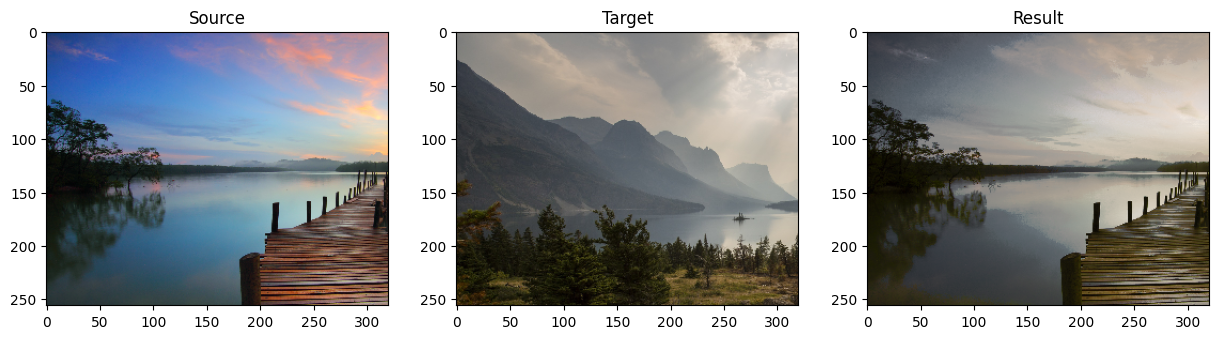

In [10]:
def optimal_transport_imgs():
    dst_multiset = dst_img_small.copy().reshape(-1, chnl)
    src_multiset = src_img_small.copy().reshape(-1, chnl)
    for _ in range(100):
        u = np.zeros(src_multiset.shape, dtype=np.float64)
        for _ in range(5):
            theta = get_vector()
            x, y = project_on_vector(src_multiset, dst_multiset, theta)
            x_sort_indx = np.argsort(x)
            y = np.sort(y)
            u[x_sort_indx] += theta * (y - x[x_sort_indx]).reshape(-1, 1) / 5.0
        src_multiset += u 
    return np.reshape(src_multiset, src_img_small.shape)

diff = optimal_transport_imgs()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(src_img_small)
axes[0].set_title('Source')

axes[1].imshow(dst_img_small)
axes[1].set_title('Target')

axes[2].imshow(diff)
axes[2].set_title('Result')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


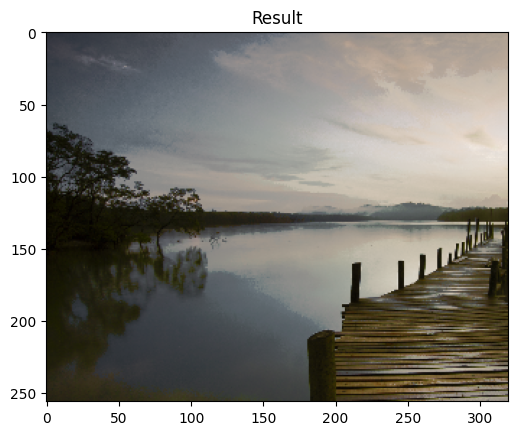

In [11]:
plt.imshow(diff)
plt.title('Result')
plt.show()